# **Data Load And Transformation**

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('Walmart.csv')

In [3]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
#check missing values
data.isnull().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


We set the date as the index to make it easier to work with time-based data. This lets us quickly filter by dates, do things like monthly averages, and keep everything in the right order.

In [5]:
#Data "Date" Tranformation

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
# Set 'Date' as index
data.set_index('Date', inplace=True)
# Sort by date
data = data.sort_index()

In [6]:
data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324
...,...,...,...,...,...,...,...
2012-10-26,25,688940.94,0,56.69,3.882,216.151590,7.293
2012-10-26,5,319550.77,0,71.70,3.506,224.037814,5.422
2012-10-26,40,921264.52,0,49.65,3.917,138.728161,4.145


In [7]:
#correlation matrix:
data.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000e+00,-0.335332,1.637929e-16,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,1.637929e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000


Since no other attribute shows a strong correlation with weekly sales, we'll build our forecast using only the time component. This means we'll rely on past sales patterns over time to predict future values.

# **Visualize initial data:**

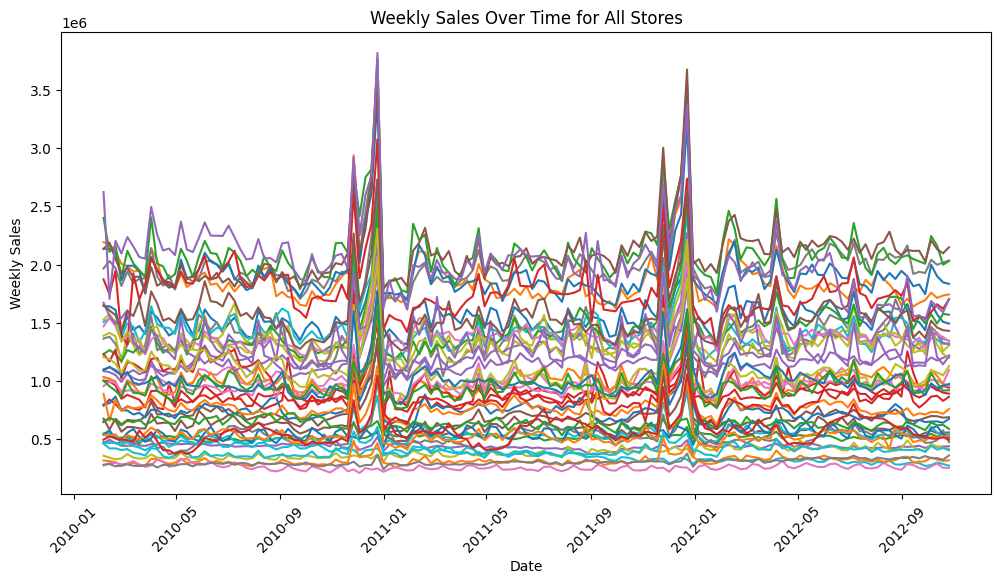

In [8]:
plt.figure(figsize=(12, 6))
for store in data['Store'].unique():
    store_data = data[data['Store'] == store]
    plt.plot(store_data.index, store_data['Weekly_Sales'], label=f"Store {store}")

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales Over Time for All Stores")
plt.xticks(rotation=45)
plt.show()

The plot shows weekly sales trends for all stores, highlighting seasonal spikes. Sales vary across stores, but a repeating pattern suggests strong seasonality. This confirms that time-based trends are key for forecasting future sales.

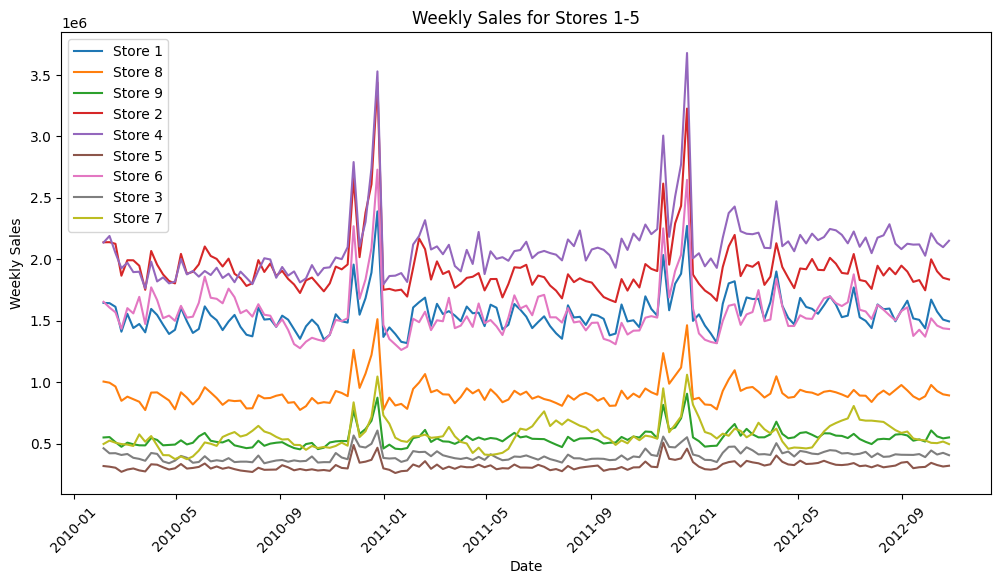

In [9]:
#Lets visualize for first 5 store to see clear picture
#Filter data for the first 5 stores
filtered_data = data[data['Store'] < 10]  # Ensure it's first 5 stores (1-5)

plt.figure(figsize=(12, 6))
for store in filtered_data['Store'].unique():
    store_data = filtered_data[filtered_data['Store'] == store]
    plt.plot(store_data.index, store_data['Weekly_Sales'], label=f"Store {store}")

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales for Stores 1-5")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Since all stores follow same pattern we can aggregate them to see global trend and see the time series decomposition. If all stores exhibit the same trend, seasonality, and overall patterns, then forecasting on aggregated data should generalize well to individual stores.

# **Data Aggregation**

In [10]:
#Aggregate data:
agg = data.groupby('Date')['Weekly_Sales'].sum()
agg

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


In [11]:
if not isinstance(agg.index, pd.DatetimeIndex):
    agg.index = pd.to_datetime(agg.index, errors='coerce')

In [12]:
if isinstance(agg, pd.Series):
    agg = agg.to_frame(name='Weekly_Sales')

<function matplotlib.pyplot.show(close=None, block=None)>

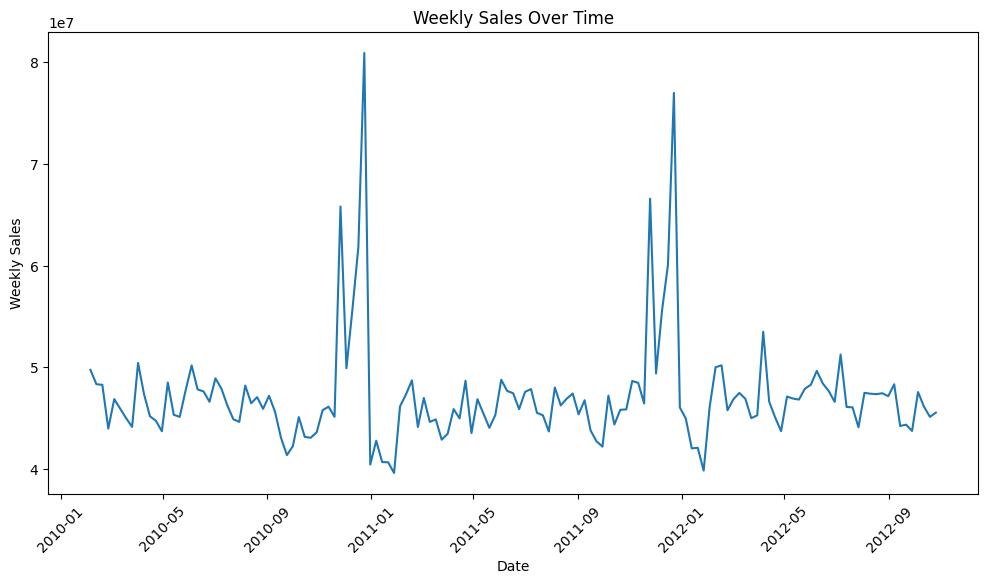

In [13]:

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(agg.index, agg['Weekly_Sales'])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales Over Time")

plt.show

# **Stationarity Test**

Stationarity is essential in time series forecasting because most models assume a constant mean and variance over time. If a series is non-stationary, we may need to differentiate or transform it for accurate predictions.


We use KPSS(Kwiatkowski-Phillips-Schmidt-Shin) test to find if series is stationary or not. KPSS assumes stationarity as the null hypothesis, making it useful for confirming stationarity rather than just detecting non-stationarity.

In [14]:
#apply kpss test:
from statsmodels.tsa.stattools import kpss

# Apply KPSS test
kpss_result = kpss(agg['Weekly_Sales'], regression='c')  # 'c' checks for stationarity around a constant (level stationarity)

# Print results
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Critical Values: {kpss_result[3]}')

# Interpretation
if kpss_result[1] < 0.05:
    print("The series is likely non-stationary (reject null hypothesis).")
else:
    print("The series is likely stationary (fail to reject null hypothesis).")


KPSS Statistic: 0.0488916291107801
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely stationary (fail to reject null hypothesis).


<ipython-input-14-8d213c92096e>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(agg['Weekly_Sales'], regression='c')  # 'c' checks for stationarity around a constant (level stationarity)


The KPSS test statistic is 0.0489, and the p-value is 0.1, which is greater than all critical values (e.g., 5% = 0.463). Since the null hypothesis (stationarity) cannot be rejected, the series is likely stationary around a constant mean according to KPSS Test. The interpolation warning suggests that the test statistic is very small, and the actual p-value is higher than 0.1. This further supports that the series is strongly stationary.

Lets visualize the data to confirm for stationarity

# **Time Series Decomposition:**

Time series decomposition helps break data into trend, seasonality, and residuals, making patterns easier to analyze. It improves forecasting by identifying trends and seasonal effects, guiding model selection. Understanding these components helps in preprocessing and choosing the right techniques, such as seasonal adjustments or specialized models like SARIMA.



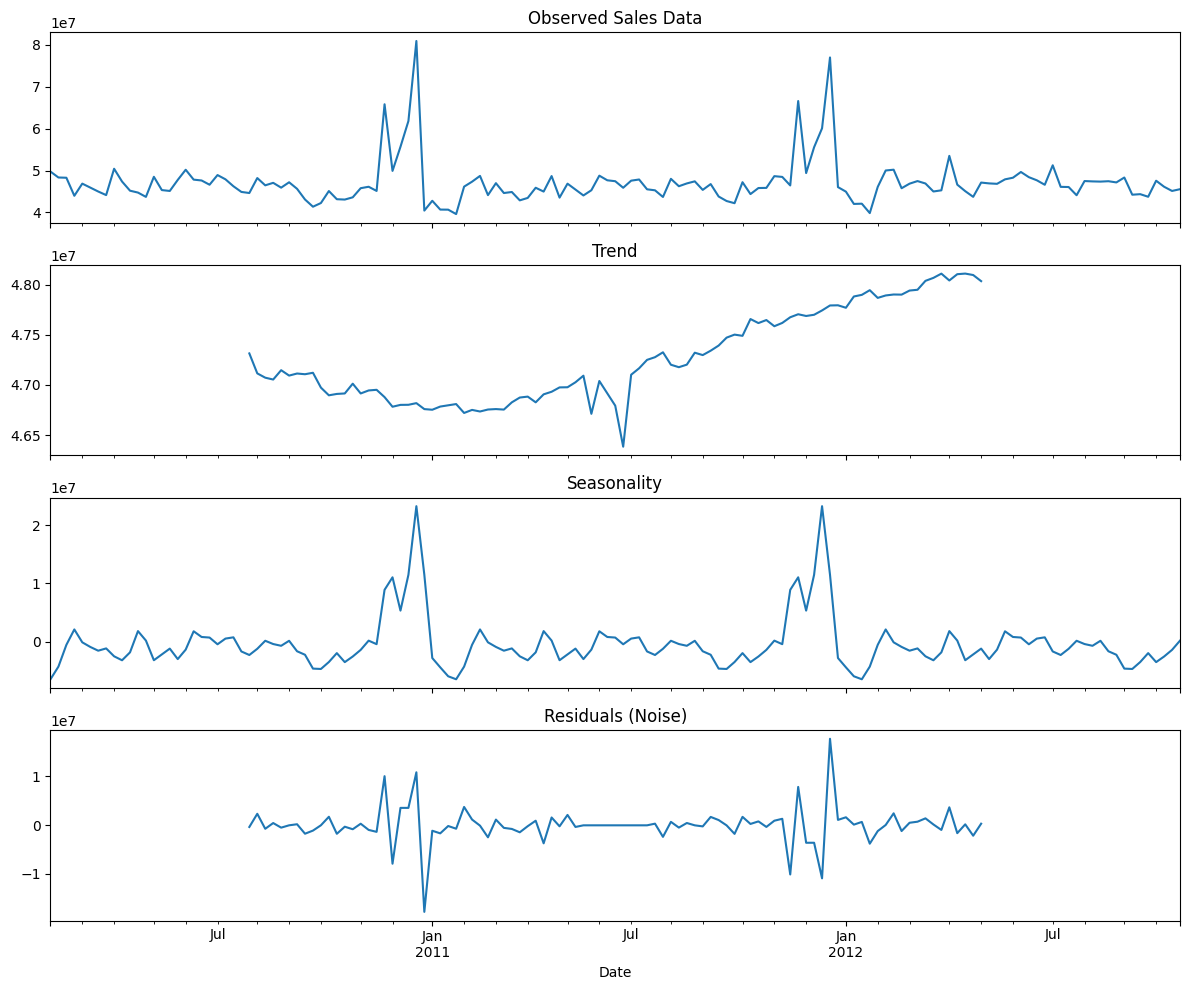

In [15]:
# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(agg, model='additive', period=51)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], title="Observed Sales Data")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals (Noise)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


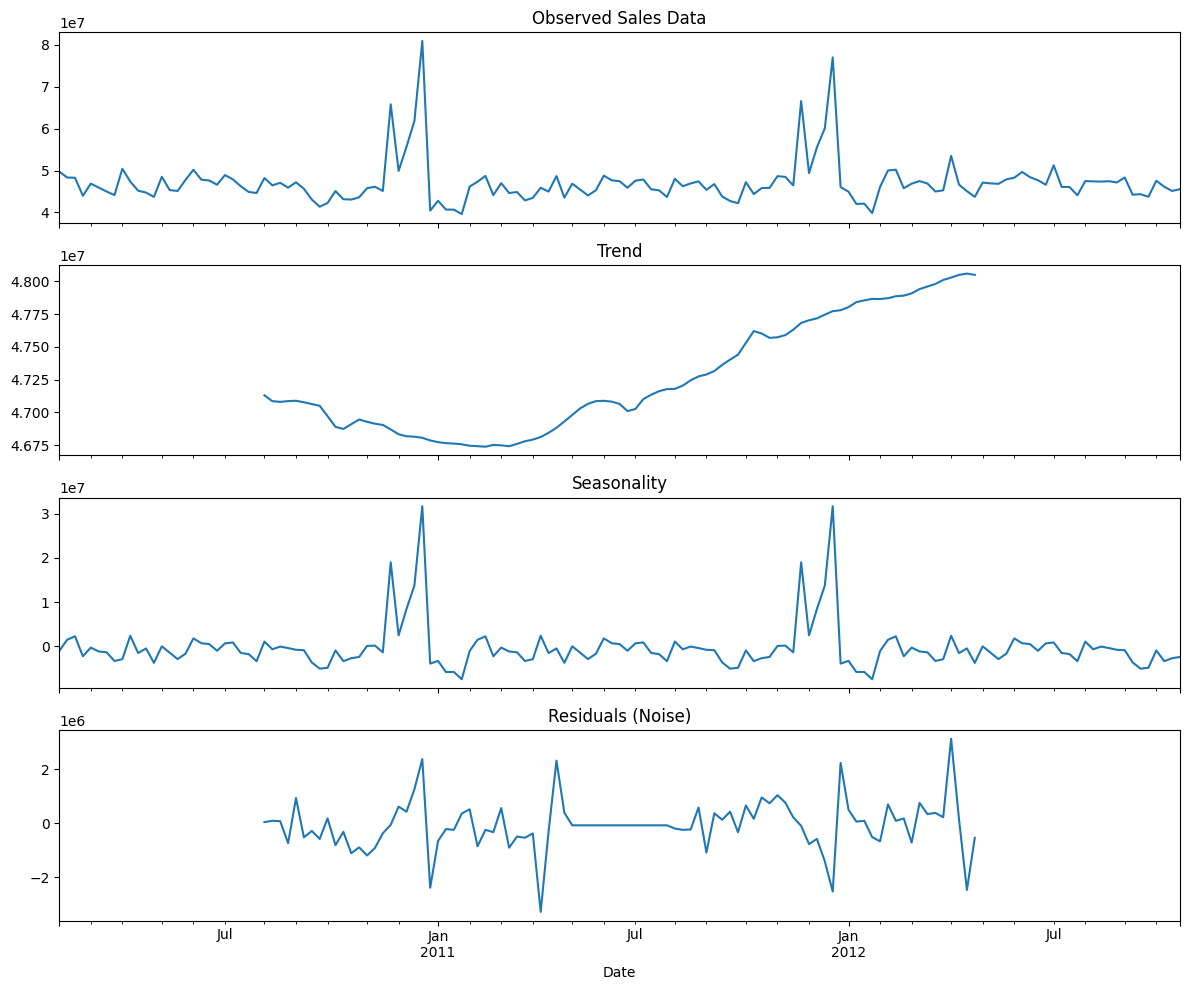

In [16]:
decomposition = sm.tsa.seasonal_decompose(agg, model='additive', period=52)  # Assuming weekly data with yearly seasonality

# Plot decomposition results
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], title="Observed Sales Data")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals (Noise)")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

Since looking at initial visualization we can see the pattern is repeating after 51,52 weeks so we tested decomposition with 51-week and 52-week periods to find the best fit. First plot is for period 51 (weeks) and second is for 52(weeks) we select the period that has no seasonal component in trend and trend is as smooth as possible. So our final perios is *52 Weeks*

A clear seasonal pattern in decomposition indicates that the series is not stationary, even if statistical tests suggest otherwise. Relying solely on tests like KPSS or ADF can be misleading. Visualizing trends and decomposition helps confirm stationarity and guides necessary transformations, like differencing, for accurate forecasting.

The result of the ADF test (𝑝-value below 0.05) suggests that the null hypothesis of presence of a unit root can be rejected at 95% confidence level.
The result of the KPSS test (𝑝-value above 0.05) suggests that the null hypothesis of absence of a unit root presence of unit root cannot be rejected at 95% confidence level. However, they are not tailored for detecting other forms of nonstationarity. Therefore, it is not surprising that they do not detect nonstationarity of the seasonal kind.

ref : https://stats.stackexchange.com/questions/225087/seasonal-data-deemed-stationary-by-adf-and-kpss-tests

# **Model Selection, Building and Forecasting**

There is no strong trend component needing removal. The seasonality is present. Even though the data is stationary: Seasonality still exists (as seen in the decomposition plot).
ARIMA alone might not capture seasonality well.
We should use SARIMA (Seasonal ARIMA) instead.

**AUTOCORRELATION**



**AutoCorrelation plot** : Autocorrelation measures how a time series correlates with its past values (lags). It helps identify patterns, trends, and seasonality by showing how strongly current values depend on previous ones. High autocorrelation at specific lags suggests repeating cycles, making it useful for time series forecasting.

The ACF plot helps identify the Moving Average (MA) order (q) by showing where autocorrelations cut off. If ACF drops to near zero after lag q, an MA(q) model is appropriate. The MA component captures past error influences, helping improve short-term predictions and model accuracy.

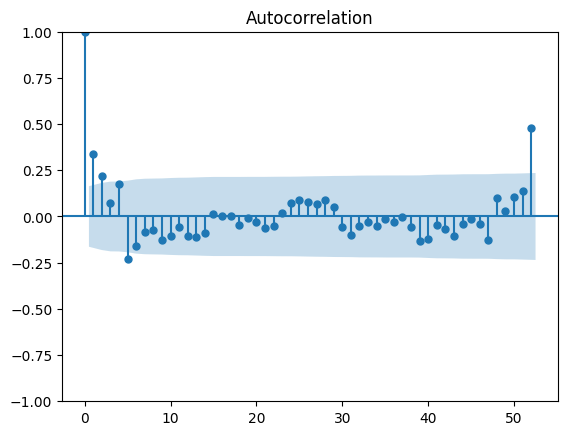

In [17]:
#acf plot:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(agg['Weekly_Sales'], lags=52)
plt.show()

The plot shows significant autocorrelation at lag 1, indicating strong dependence on the previous value. A spike at lag ~52 suggests seasonality, likely a yearly pattern in weekly data. Most other lags fall within the confidence interval, meaning limited long-term dependency.

We choose q by identifying the lag where the ACF sharply cuts off (drops near zero). Lags inside the blue region are not considered because they are statistically insignificant (fall within the confidence interval). From the plot, significant spikes at lag 1 and lag 52 suggest possible MA components.

**PARTIAL AUTOCORRELATION**

Partial autocorrelation measures the direct relationship between a time series and its past values, removing the influence of intermediate lags. It helps identify how strongly each lag individually impacts the current value, making it useful for detecting autoregressive behavior.


The PACF plot helps determine the Autoregressive (AR) order (p) by showing where partial correlations cut off. If PACF drops to near zero after lag p, an AR(p) model is appropriate. The AR component captures direct dependencies on past values, improving long-term forecasting accuracy.

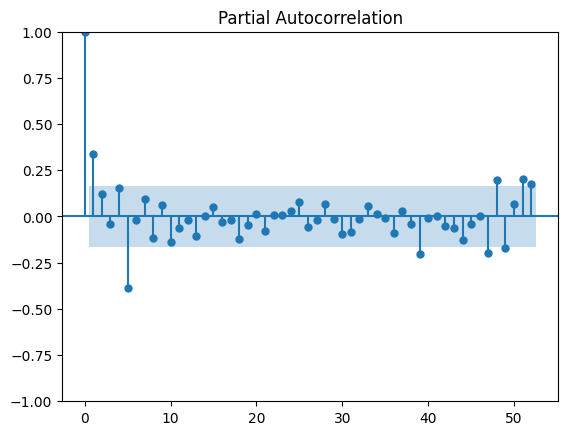

In [18]:
#partialautocorrelation plot:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(agg['Weekly_Sales'], lags=52)
plt.show()

The plot shows significant partial autocorrelation at lag 1, indicating strong dependence on the previous value. A drop after lag 1 suggests that only recent past values directly influence the series, while a spike around lag 52 suggests a seasonal effect in the data. Most other lags fall within the confidence interval, meaning their impact is statistically insignificant.

We choose p by identifying the lag where the PACF sharply cuts off (drops near zero). Lags inside the blue region are not considered as they are statistically insignificant. From the plot, the significant spike at lag 1 suggests an AR(1) component, and the spike at lag 52 indicates potential seasonality in the autoregressive structure.

**SARIMA MODEL DEVELOPMENT**

The SARIMA (Seasonal AutoRegressive Integrated Moving Average) model is an extension of ARIMA that handles seasonal patterns in time series data. It combines:

AR (AutoRegressive) – Uses past values to predict future values.
I (Integrated) – Differencing to make the series stationary.
MA (Moving Average) – Uses past forecast errors to improve predictions.
Seasonal Component (S, P, D, Q, m) – Captures repeating patterns at fixed intervals (e.g., yearly seasonality in weekly sales).
SARIMA is useful when data exhibits seasonal fluctuations, making it a powerful model for forecasting time series with trends and seasonality.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


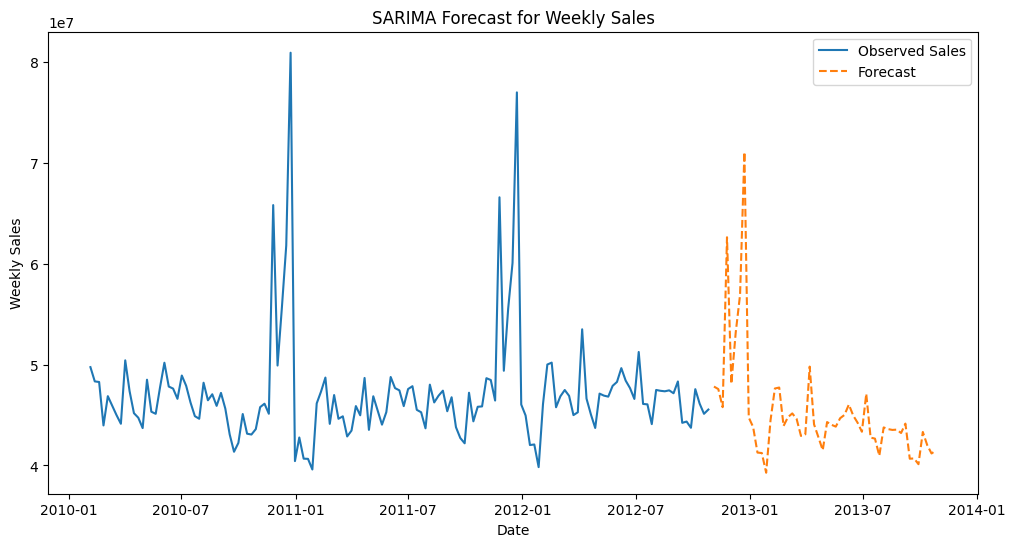

In [29]:
agg = agg.astype(float)

# Fit SARIMA model (p, d, q) x (P, D, Q, s) where s=52 (weekly seasonality)
sarima_model = sm.tsa.statespace.SARIMAX(agg,
                                         order=(1, 0, 1),  # ARIMA terms (d=0 since stationary)
                                         seasonal_order=(1, 0, 1, 52),  # Seasonal terms
                                         enforce_stationarity=False,
                                         enforce_invertibility=False).fit()

# Forecast next 52 weeks
forecast_steps = 52
forecast = sarima_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=agg.index[-1], periods=forecast_steps+1, freq='W')[1:]
forecast_values = forecast.predicted_mean

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(agg.index, agg, label="Observed Sales")
plt.plot(forecast_index, forecast_values, label="Forecast", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("SARIMA Forecast for Weekly Sales")
plt.legend()
plt.show()


The plot shows the actual weekly sales (blue line) and the forecasted sales (orange dashed line) using the SARIMA model.

The model captures seasonal patterns, as seen in the recurring peaks and fluctuations.
The forecast follows the historical trend, but there is some variability in the predicted values.
Significant sales spikes are observed in both historical and forecasted periods, suggesting seasonal demand fluctuations.
The model appears to provide a reasonable projection of future sales, though uncertainty increases over time.
Overall, the SARIMA model effectively incorporates seasonality and trends, making it useful for time series forecasting.

**Forecasting Values for stores**

We trained a SARIMA model on aggregated weekly sales data to capture overall seasonality and trends across all stores. Since, store-level patterns align with overall trends, instead of building separate models per store, we will use this global model to forecast total future sales. These forecasts can then be proportionally distributed to individual stores based on their historical sales contributions.

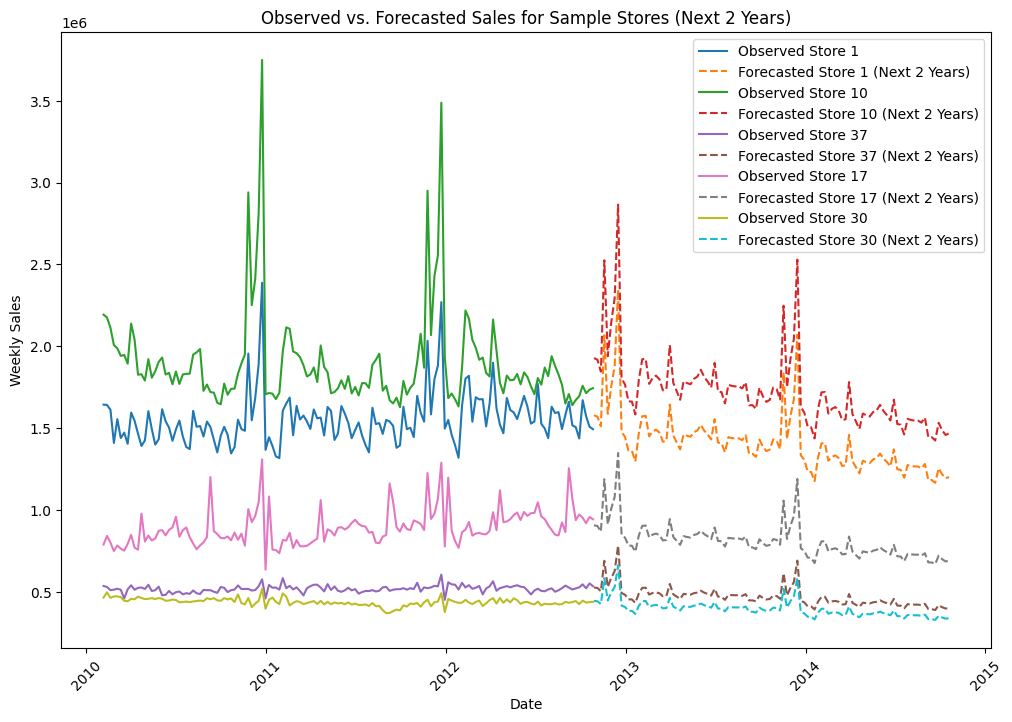

In [26]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Forecast for the Next Two Years Using the Trained SARIMA Model
train_size = 52
forecast_steps = 104  # 2 years = 104 weeks

# Prepare store-level forecast results dictionary
store_forecast_results = {}

for store in data['Store'].unique():
    store_data = data[data['Store'] == store].copy()
    store_data = store_data.sort_index()

    # Forecast using the SARIMA model trained on aggregated data
    forecast_total = sarima_model.get_forecast(steps=forecast_steps)
    forecast_total_values = forecast_total.predicted_mean

    # Use last known proportion to distribute total forecast to stores
    store_proportion = store_data['Weekly_Sales'].sum() / agg['Weekly_Sales'].sum()
    forecast_store_values = forecast_total_values * store_proportion

    # Store results
    store_forecast_results[store] = forecast_store_values.values

# Generate forecast index using the last available date from `data`
forecast_index = pd.date_range(start=data.index[-1], periods=len(forecast_total_values), freq='W')

# Convert results into a DataFrame with corrected index length
forecast_store_df = pd.DataFrame(store_forecast_results, index=forecast_index)

# Ensure index is in datetime format
forecast_store_df.index.name = "Date"

# Step 6: Visualize Forecasts Across Multiple Stores with Continuation
plt.figure(figsize=(12, 8))

# Select a few sample stores for visualization (first 5 stores)
sample_stores = list(store_forecast_results.keys())[:5]

for store in sample_stores:
    store_data = data[data['Store'] == store].copy()

    # Since Date is already an index, we don't need to reset it
    actual_values = store_data['Weekly_Sales'].astype(float)
    forecast_values = forecast_store_df[store]

    # Plot actual sales (training period)
    plt.plot(actual_values.index, actual_values, label=f"Observed Store {store}", linestyle='solid')

    # Plot forecasted sales (continuation)
    plt.plot(forecast_values.index, forecast_values, label=f"Forecasted Store {store} (Next 2 Years)", linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Observed vs. Forecasted Sales for Sample Stores (Next 2 Years)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


The plot shows observed vs. forecasted weekly sales for a sample of stores over time. For most stores, the forecasted sales closely follow the level and seasonal patterns seen in the historical data, especially in stores like Store 1 and Store 10. The forecasts capture repeating annual spikes, suggesting the model has learned the seasonality. The transitions between observed and forecasted sections are smooth, indicating good continuity. However, because the same SARIMA model was used across stores with scaling, store-specific anomalies or unique trends may not be captured, especially in lower-volume stores like Store 30.
Overall, the forecasts appear reasonable and consistent with past behavior, supporting the assumption that stores follow a common seasonal pattern.